# COVID 19 classification


Version 3, November 2020, working on fastai v2.
Main changes: 
- Training using hmhospitales dataset and rsna pneumonia challenge.

In [4]:
 import os
 os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
 os.environ['CUDA_VISIBLE_DEVICES']='1'


In [17]:
import gc


In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [14]:
from fastai.vision.all import *
from fastai.metrics import error_rate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import fastai; fastai.__version__

from sklearn.model_selection import train_test_split



In [18]:
torch.cuda.is_available()

True

In [9]:
#!pip list


If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [20]:
bs = 16
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
size_1 = 256
size_2 = 512

## data

In [21]:
path ='/home/robert/data/covid/'; path

'/home/robert/data/covid/'

### Load Normal and pneumonia from RSNA Pneumonia dataset 

In [102]:
dfTrain = pd.read_csv(path+'train_RSNA_processed.csv', header=None)
dfTrain['valid'] = 0
dfTrain[0] = 'train_RSNA/processed/' + dfTrain[0].astype(str)

# # adding padchest
dfTrain_padchest = pd.read_csv(path+'padchest/train_split_np.csv', header=None)
dfTrain_padchest['valid'] = 0
dfTrain_padchest[0] = 'padchest/trainNP/processed/' + dfTrain_padchest[0].astype(str)

dfTrain = dfTrain.append(dfTrain_padchest)
print('Normal train '+str(len (dfTrain)))
dfTrain.head()

Normal train 21743


,0,1,valid
0,train_RSNA/processed/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,normal,0
1,train_RSNA/processed/009eb222-eabc-4150-8121-d5a6d06b8ebf.png,normal,0
2,train_RSNA/processed/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.png,normal,0
3,train_RSNA/processed/017c7b5b-618e-4bc9-943c-04c6a988d992.png,normal,0
4,train_RSNA/processed/019ca122-9cdf-4704-b7a9-449c8a1c263e.png,normal,0


### Load COVID for training from hmhospitales

In [103]:
dfTrainCovid = pd.read_csv(path+'hmhospitales/train_hmh_processed.csv', header=None)
dfTrainCovid['valid'] = 0
dfTrainCovid[0] = 'hmhospitales/train/processed/' + dfTrainCovid[0].astype(str)
print("HMH: ", len (dfTrainCovid))

dfTrainv3 = pd.read_csv(path+'train_split_v3.csv', header=None)
dfTrainv3['valid'] = 0
dfTrainv3[0] = 'train/processed/' + dfTrainv3[0].astype(str)
dfTrainv3 = dfTrainv3.loc[dfTrainv3[1] == 'COVID-19']
# augment de training covid data 2^3
for i in range(2):
    dfTrainv3 = dfTrainv3.append(dfTrainv3)
print("Splitv3: ", len (dfTrainv3))
    
dfTrainCovid = dfTrainCovid.append(dfTrainv3)


# salutms_xnat (217 cases)
df_salut = pd.read_csv(path+'salutms_xnat/salutms_xnat2.csv',header=None)
df_salut[0] = 'salutms_xnat/img/processed/' + df_salut[0].astype(str)
df_salut.loc[df_salut[1] == ('Cardiopatia') , 1] = 'normal'
df_salut.loc[df_salut[1] == ('Fractura') , 1] = 'normal'
df_salut = df_salut.drop(2, 1)

df_train_salut, df_test_salut = train_test_split(df_salut, test_size=0.5)

# augment de training covid data 2^3
for i in range(3):
    df_train_salut = df_train_salut.append(df_train_salut)
print("Salutms: ", len (df_train_salut))
dfTrainCovid = dfTrainCovid.append(df_train_salut)

print(len (dfTrainCovid))
dfTrainCovid.head()


HMH:  2030
Splitv3:  1084
Salutms:  840
3954


,0,1,valid
0,hmhospitales/train/processed/1.2.124.113532.1266916631811037527143121792217253173208.DC3.png,COVID-19,0.0
1,hmhospitales/train/processed/1.2.124.113532.1291042221721822374531691781477817424919248.DC3.png,COVID-19,0.0
2,hmhospitales/train/processed/1.2.124.113532.14215919646721317727155472551352231942291.DC3.png,COVID-19,0.0
3,hmhospitales/train/processed/1.2.124.113532.144481397388233672417416612413319418444233.DC3.png,COVID-19,0.0
4,hmhospitales/train/processed/1.2.124.113532.15417119511021296751221372221359244236113232.DC3.png,COVID-19,0.0


Join Normals and covids for training


In [104]:
dfTrain = dfTrain.append(dfTrainCovid)
print('Total Train',len (dfTrain))
dfTrain.head()

Total Train 25697


,0,1,valid
0,train_RSNA/processed/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,normal,0.0
1,train_RSNA/processed/009eb222-eabc-4150-8121-d5a6d06b8ebf.png,normal,0.0
2,train_RSNA/processed/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.png,normal,0.0
3,train_RSNA/processed/017c7b5b-618e-4bc9-943c-04c6a988d992.png,normal,0.0
4,train_RSNA/processed/019ca122-9cdf-4704-b7a9-449c8a1c263e.png,normal,0.0


### Validation data test set in RSNA and HMH

In [105]:
dfTest = pd.read_csv(path+'test_RSNA_processed.csv',header=None)
dfTest['valid'] = 1
dfTest[0] = 'test_RSNA/processed/' + dfTest[0].astype(str)
print('Test RSNA',len (dfTest))
dfTest.head()

Test RSNA 1463


,0,1,valid
0,test_RSNA/processed/009482dc-3db5-48d4-8580-5c89c4f01334.png,normal,1
1,test_RSNA/processed/00a85be6-6eb0-421d-8acf-ff2dc0007e8a.png,normal,1
2,test_RSNA/processed/00f87de5-5fe0-4921-93ea-914d7e683266.png,normal,1
3,test_RSNA/processed/01f11e57-5c11-4ab0-9312-d88c3826721c.png,normal,1
4,test_RSNA/processed/029216c8-ea0d-47bb-88fd-bf611cc5d1fc.png,normal,1


In [106]:
dfTestCovid = pd.read_csv(path+'hmhospitales/test_hmh_processed.csv',header=None)
dfTestCovid['valid'] = 1
dfTestCovid[0] = 'hmhospitales/test/processed/' + dfTestCovid[0].astype(str)
print('Test HMH ',len (dfTestCovid))

dfTestCovid = dfTestCovid.append(df_test_salut)




dfTestCovid.head()


Test HMH  534


,0,1,valid
0,hmhospitales/test/processed/1.2.124.113532.161153445713587119186200205842188946159.DC3.png,COVID-19,1.0
1,hmhospitales/test/processed/1.2.124.113532.1721085174194116651881671414812810016636105.DC3.png,COVID-19,1.0
2,hmhospitales/test/processed/1.2.124.113532.2293182203380643613922724523119131287.DC3.png,COVID-19,1.0
3,hmhospitales/test/processed/1.2.840.113619.2.202.4.2147483647.1585896668.811080.DC3.png,COVID-19,1.0
4,hmhospitales/test/processed/1.2.840.113619.2.202.4.2147483647.1586039283.272517.DC3.png,COVID-19,1.0


In [107]:
dfTest= dfTest.append(dfTestCovid)
print('Total Test',len (dfTest))

Total Test 2103


In [108]:
df = dfTrain.append(dfTest)
df.head()

,0,1,valid
0,train_RSNA/processed/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,normal,0.0
1,train_RSNA/processed/009eb222-eabc-4150-8121-d5a6d06b8ebf.png,normal,0.0
2,train_RSNA/processed/01027bc3-dc40-4165-a6c3-d6be2cb7ca34.png,normal,0.0
3,train_RSNA/processed/017c7b5b-618e-4bc9-943c-04c6a988d992.png,normal,0.0
4,train_RSNA/processed/019ca122-9cdf-4704-b7a9-449c8a1c263e.png,normal,0.0


In [25]:
# change into 2 class problem covid NOCOVID
# df.loc[df[1] == ('pneumonia' or 'normal') , 1] = NOCOVID


In [109]:
def get_dls(bs, size,df):
    tfms = [*aug_transforms(size = size, do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,\
        max_warp=0.,pad_mode='reflection', max_rotate=5),Normalize.from_stats(*imagenet_stats)]
    dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                splitter=ColSplitter(col='valid'),
                get_x=ColReader(0, pref=path),
                get_y=ColReader(1),
                item_tfms = Resize(600),
                batch_tfms =tfms)                      
    return dblock.dataloaders(df, bs=bs)

In [110]:
np.random.seed(42)



dls = get_dls(64, 224,df)

# tfms = [*aug_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,\
#      max_warp=0.,pad_mode='reflection', max_rotate=5),Normalize.from_stats(*imagenet_stats)]
# dls = ImageDataLoaders.from_df(df=df,path=path,  convert_mode='L', valid_col='valid', batch_tfms =tfms,
#                               bs = bs, item_tfms = Resize(size = size_1, method ='squish'))

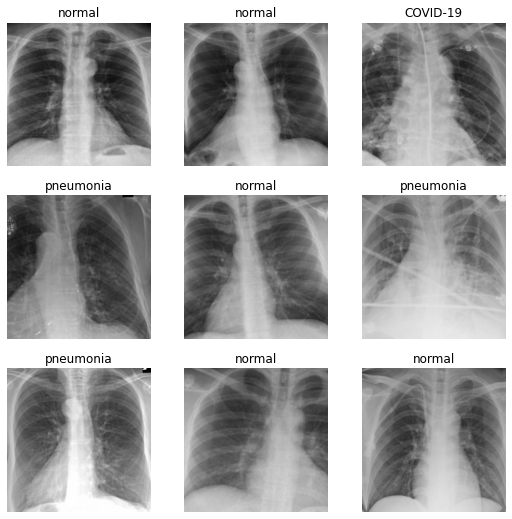

In [111]:
dls.show_batch()

In [112]:
len(dls.train_ds)

24857

In [113]:
len(dls.valid_ds)


2943

In [114]:
dls.valid_ds


(#2943) [(PILImageBW mode=L size=2815x2755, TensorCategory(0)),(PILImageBW mode=L size=1971x1338, TensorCategory(0)),(PILImageBW mode=L size=2937x2221, TensorCategory(0)),(PILImageBW mode=L size=2231x1481, TensorCategory(0)),(PILImageBW mode=L size=1814x1253, TensorCategory(1)),(PILImageBW mode=L size=3244x2297, TensorCategory(0)),(PILImageBW mode=L size=1890x1278, TensorCategory(1)),(PILImageBW mode=L size=2049x1767, TensorCategory(1)),(PILImageBW mode=L size=1476x1282, TensorCategory(0)),(PILImageBW mode=L size=3384x2211, TensorCategory(0))...]

## learner

In [180]:
torch.cuda.empty_cache()

In [181]:
dls = get_dls(128, 128,df)
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), \
                metrics= [accuracy, Precision(average='weighted'), Recall(average='weighted'), error_rate])


In [182]:
#learn.lr_find()

In [183]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.682182,1.589277,0.617426,0.717067,0.617426,0.382574,01:17
1,0.502653,0.508673,0.799199,0.840247,0.799199,0.200801,01:20
2,0.419773,0.317119,0.886830,0.887893,0.886830,0.113170,01:15
3,0.336770,0.238198,0.911367,0.914094,0.911367,0.088633,01:17


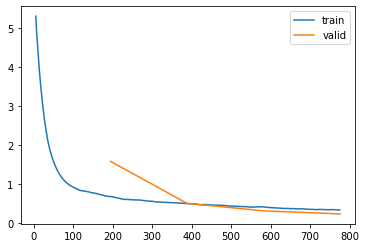

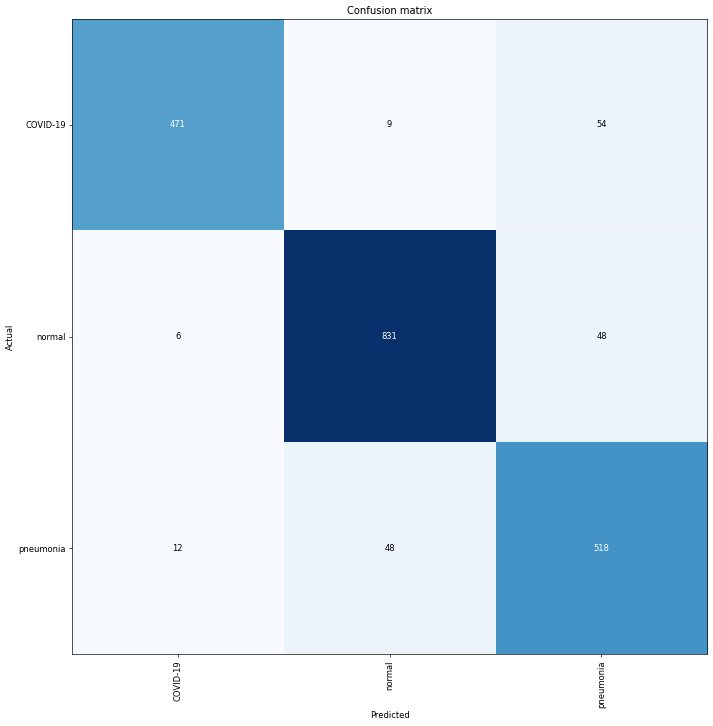

In [184]:
learn.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [185]:
cm = interp.confusion_matrix()
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

[0.88202247 0.93898305 0.89619377]


In [186]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

[0.96319018 0.93581081 0.83548387]


## Increase the size


In [187]:
learn.dls = get_dls(64, 224,df)
#learn.fit_one_cycle(5, base_lr=3e-4, freeze_epochs=5)
learn.fine_tune(5, base_lr=3e-3)


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.522690,0.489202,0.804707,0.830824,0.804707,0.195293,02:20


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.397319,0.303259,0.886329,0.891849,0.886329,0.113671,02:19
1,0.372173,0.542398,0.791187,0.825695,0.791187,0.208813,02:20
2,0.327846,0.236090,0.915373,0.916977,0.915373,0.084627,02:19
3,0.273538,0.182794,0.929394,0.931457,0.929394,0.070606,02:20
4,0.242828,0.160758,0.940911,0.941429,0.940911,0.059089,02:19


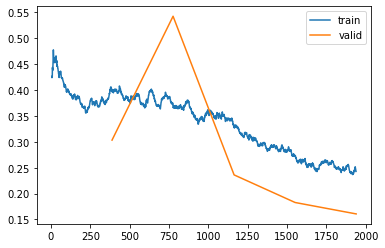

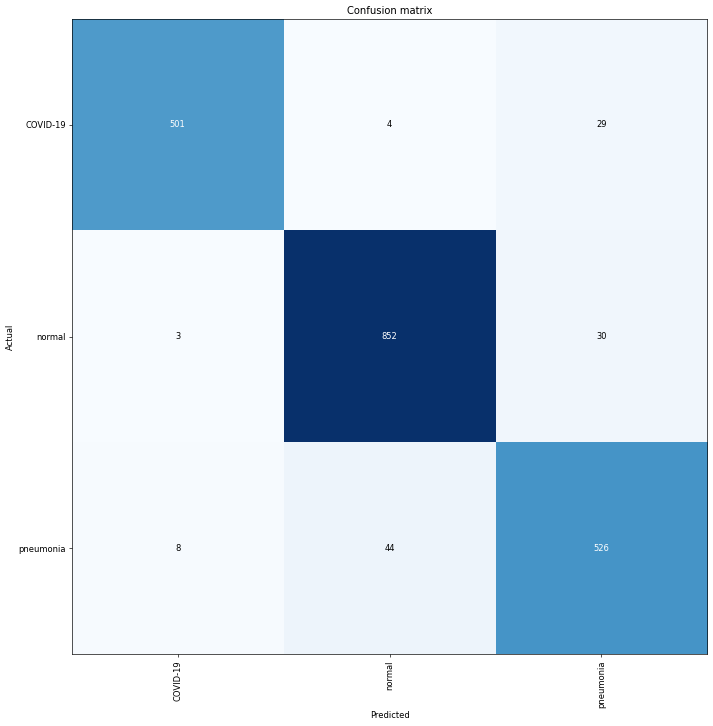

In [188]:
learn.recorder.plot_loss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [189]:
cm = interp.confusion_matrix()
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

[0.93820225 0.96271186 0.9100346 ]


In [190]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

[0.97851562 0.94666667 0.8991453 ]


## Increase the size


In [191]:
gc.collect();

In [192]:

learn.dls = get_dls(32, 512,df)
#learn.fit_one_cycle(5, base_lr=3e-4, freeze_epochs=5)
learn.fine_tune(10, base_lr=3e-3)


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.606830,0.447480,0.844767,0.849564,0.844767,0.155233,11:21


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,error_rate,time
0,0.396920,0.227595,0.914372,0.914155,0.914372,0.085628,11:10
1,0.390821,0.515768,0.810215,0.856716,0.810215,0.189785,11:05
2,0.375783,0.240088,0.915874,0.917187,0.915874,0.084126,11:11
3,0.399191,0.195629,0.931397,0.931872,0.931397,0.068603,11:13
4,0.279761,0.146999,0.949925,0.949944,0.949925,0.050075,11:06
5,0.306449,0.126151,0.951928,0.952214,0.951928,0.048072,11:15
6,0.252382,0.129653,0.954432,0.955099,0.954432,0.045568,11:09
7,0.214102,0.113752,0.959439,0.959538,0.959439,0.040561,11:02
8,0.198346,0.105091,0.960941,0.960948,0.960941,0.039059,11:10
9,0.168924,0.102187,0.963946,0.963904,0.963946,0.036054,11:00


In [193]:
# lr_min,lr_steep = learn.lr_find()
# print(lr_min, lr_steep)

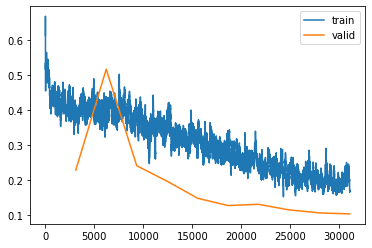

In [194]:
learn.recorder.plot_loss()

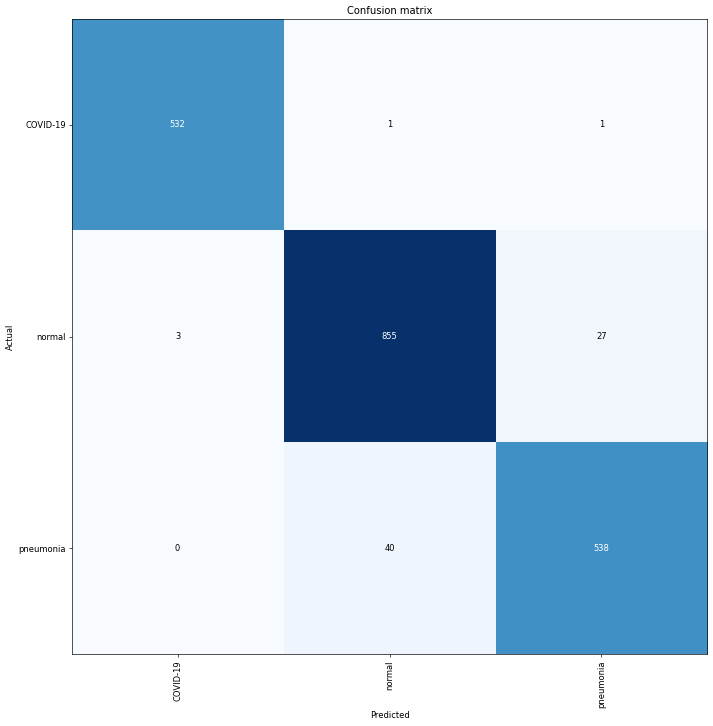

In [195]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [196]:
learn.save('stage-1_2-'+str(size_1)+'-dn50v2')

Path('models/stage-1_2-256-dn50v2.pth')

In [197]:
interp.most_confused(min_val=1)

[('pneumonia', 'normal', 40),
 ('normal', 'pneumonia', 27),
 ('normal', 'COVID-19', 3),
 ('COVID-19', 'normal', 1),
 ('COVID-19', 'pneumonia', 1)]

In [198]:
cm = interp.confusion_matrix()


In [199]:
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

[0.99625468 0.96610169 0.93079585]


In [200]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

[0.99439252 0.95424107 0.95053004]


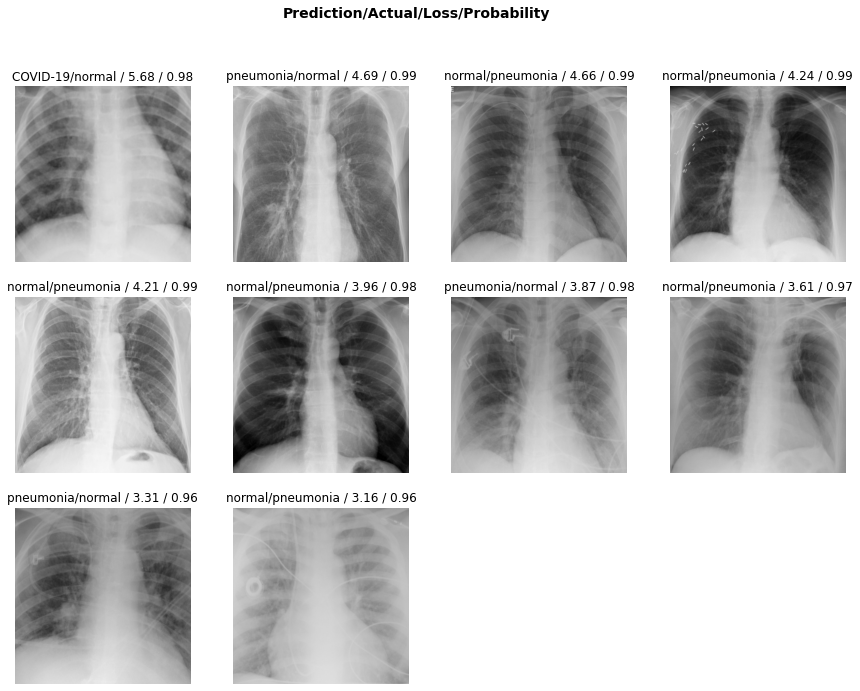

In [203]:
interp.plot_top_losses(10, figsize=(15,11), largest=True)

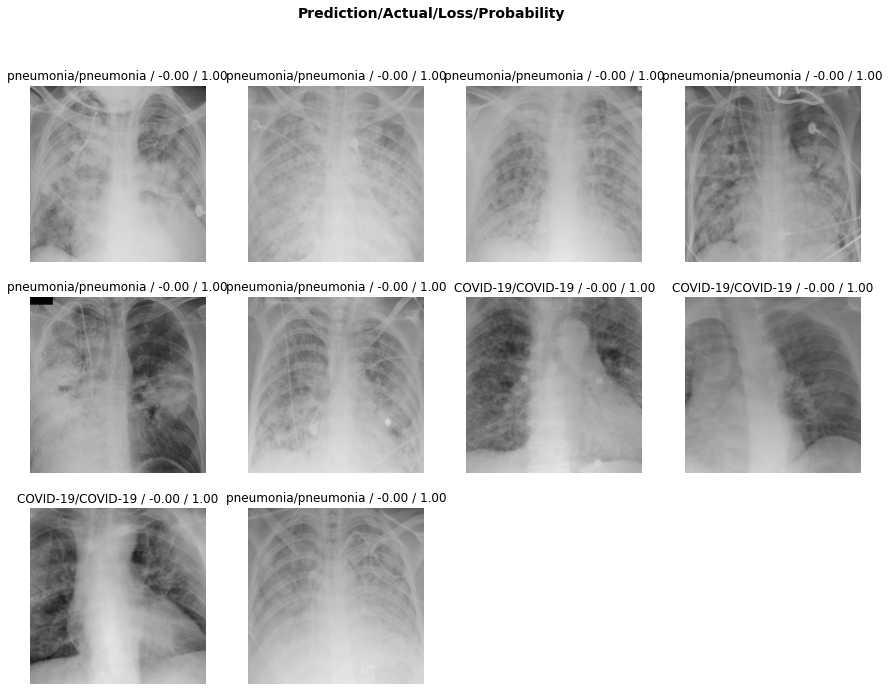

In [204]:
interp.plot_top_losses(10, figsize=(15,11), largest=False)

In [205]:
learn.export(path+'trainedAllData_resnet_ROI_'+str(size_2)+'_export_v2.pkl')

### Test on new data

In [22]:
learn = load_learner(path+'trainedAllData_resnet_ROI_'+str(size_2)+'_export_v2.pkl', cpu=False)


In [31]:
# Data from trueta, Tic Salut, Udiat

dfTest = pd.read_csv(path+'covid_local/covid_local_APonly.csv',header=None)
dfTest[0] = 'covid_local/processed/' + dfTest[0].astype(str)

#CSMS (earlier files <20 cases)
dfTest2 = pd.read_csv(path+'CSMS/CSMS.csv',header=None)
dfTest2[0] = 'CSMS/processed/' + dfTest2[0].astype(str)
dfTest2.head()
dfTest = dfTest.append(dfTest2)

# # padchest to include normals and pneumonia (not used for training/validation/testing)
dfTest3 = pd.read_csv(path+'padchest/test_split_np.csv',header=None)
dfTest3[0] = 'padchest/testNP/processed/' + dfTest3[0].astype(str)
dfTest3.head()
dfTest = dfTest.append(dfTest3)

#salutms (120 cases)
dfTest4 = pd.read_csv(path+'salutms/salutms_detect.csv',header=None)
dfTest4[0] = 'salutms/processed/' + dfTest4[0].astype(str)

dfTest = dfTest.append(dfTest4)
# dfTest = dfTest4


print(len(dfTest))
dfTest.head()

1337


,0,1
0,covid_local/processed/001_covid.png,COVID-19
1,covid_local/processed/002_covid.png,COVID-19
2,covid_local/processed/003_covid.png,COVID-19
3,covid_local/processed/004_covid.png,COVID-19
4,covid_local/processed/005_covid.png,COVID-19


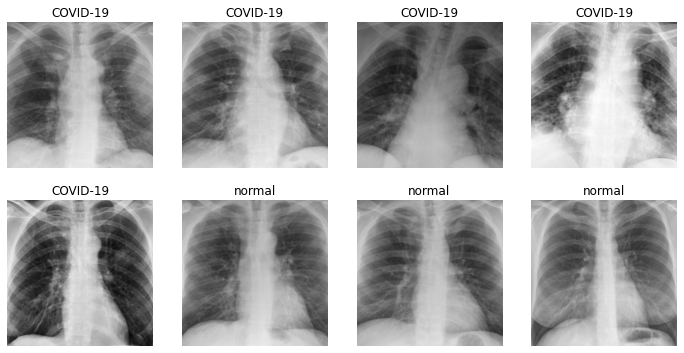

In [32]:
dl = learn.dls.test_dl(dfTest, with_labels= True, device="cuda")
dl.show_batch()

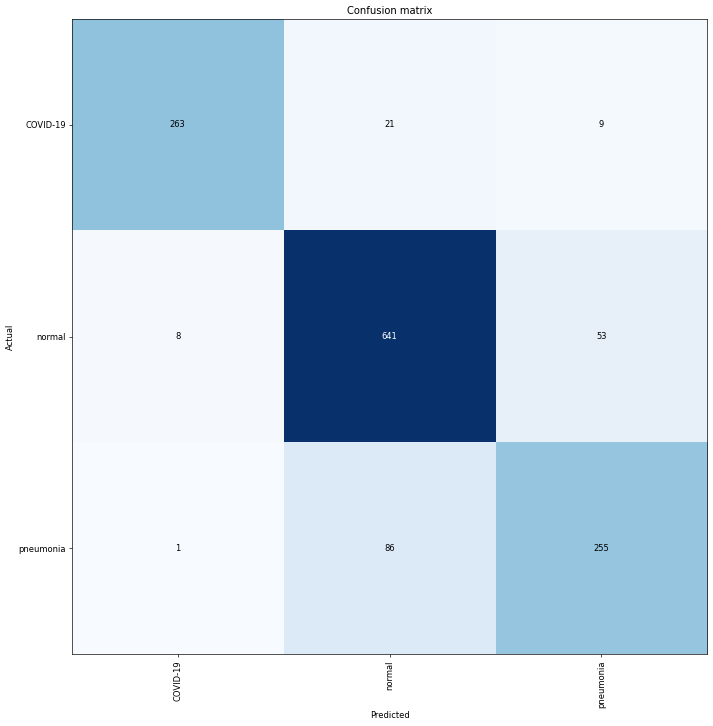

In [33]:
# preds = learn.get_preds(dl=dl)[0].numpy()
interp = ClassificationInterpretation.from_learner(learn, dl=dl)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [34]:
preds = learn.get_preds(dl=dl)
learn.validate(dl=dl)
accuracy(preds[0], preds[1])

TensorCategory(0.8669)

In [35]:
cm = interp.confusion_matrix()


In [36]:
sens = np.zeros(3)
sens[0] = cm[0,0]/np.sum(cm[0,:])
sens[1] = cm[1,1]/np.sum(cm[1,:])
sens[2] = cm[2,2]/np.sum(cm[2,:])
print(sens)

[0.89761092 0.91310541 0.74561404]


In [37]:
spec = np.zeros(3)
spec[0] = cm[0,0]/np.sum(cm[:,0])
spec[1] = cm[1,1]/np.sum(cm[:,1])
spec[2] = cm[2,2]/np.sum(cm[:,2])
print(spec)

[0.96691176 0.85695187 0.8044164 ]


In [60]:
# old version.
# log_preds, y = learn.get_preds()

# predIdxs = np.argmax(log_preds.numpy(), axis=1)
# print(exp(log_preds))



tensor([[1.0000, 1.0004, 2.7172],
        [2.7145, 1.0013, 1.0001],
        [1.0000, 1.0000, 2.7183],
        ...,
        [1.0000, 2.7183, 1.0000],
        [1.0000, 2.7176, 1.0003],
        [2.6264, 1.0000, 1.0350]])


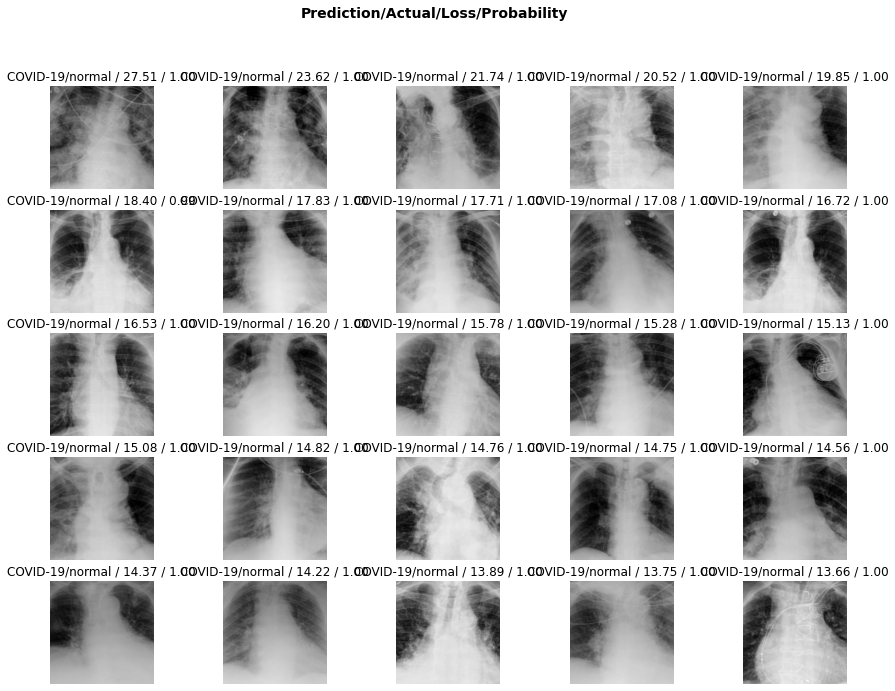

In [81]:
interp.plot_top_losses(25, figsize=(15,11), largest=True)

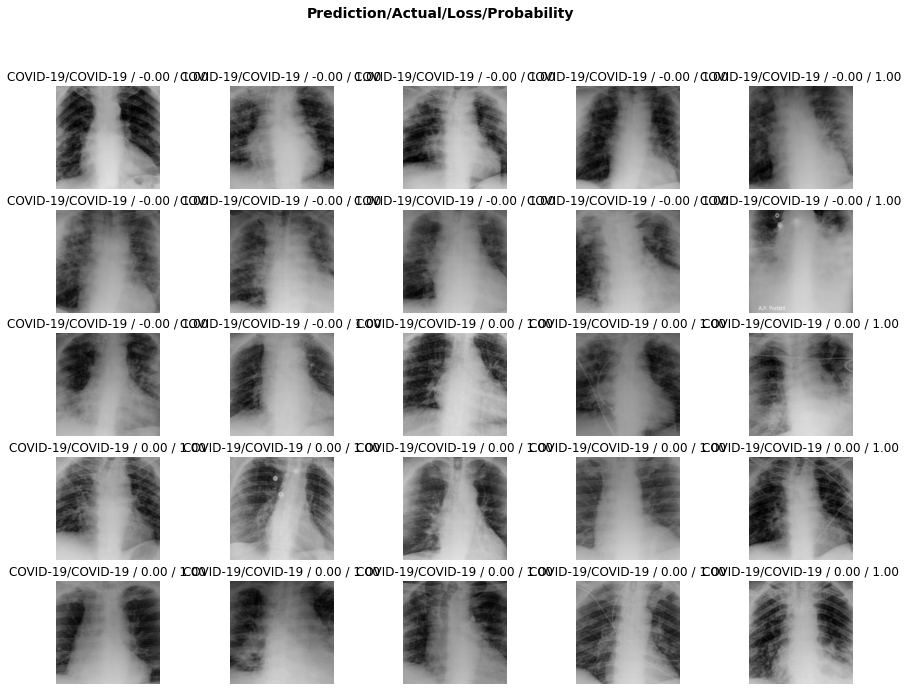

In [82]:
interp.plot_top_losses(25, figsize=(15,11), largest=False)